In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Cloning https://github.com/openai/CLIP.git to c:\users\admin\appdata\local\temp\pip-req-build-z_zbomlo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\admin\AppData\Local\Temp\pip-req-build-z_zbomlo'

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch

print("PyTorch version:", torch.__version__)

PyTorch version: 1.13.1


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("模型参数：", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("输入分辨率：", input_resolution)
print("上下文大小：", context_length)
print("词表大小：", vocab_size)

模型参数： 151,277,313
输入分辨率： 224
上下文大小： 77
词表大小： 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001E14CCCE310>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [7]:
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image

descriptions = {
    "chelsea": "a facial photo of a tabby cat",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

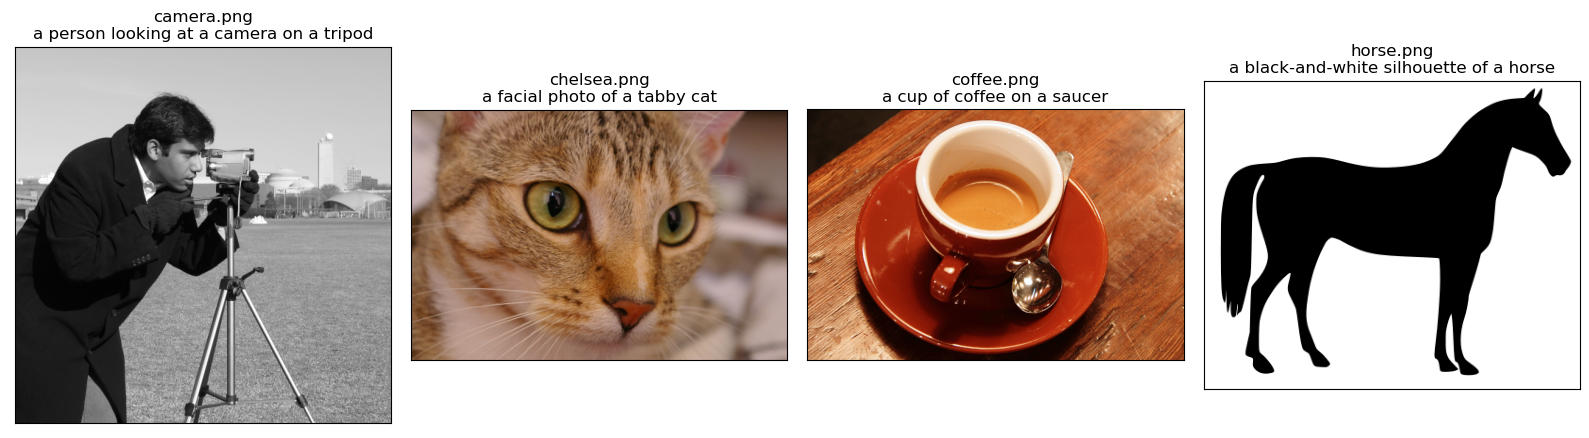

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(1, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

In [9]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [10]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

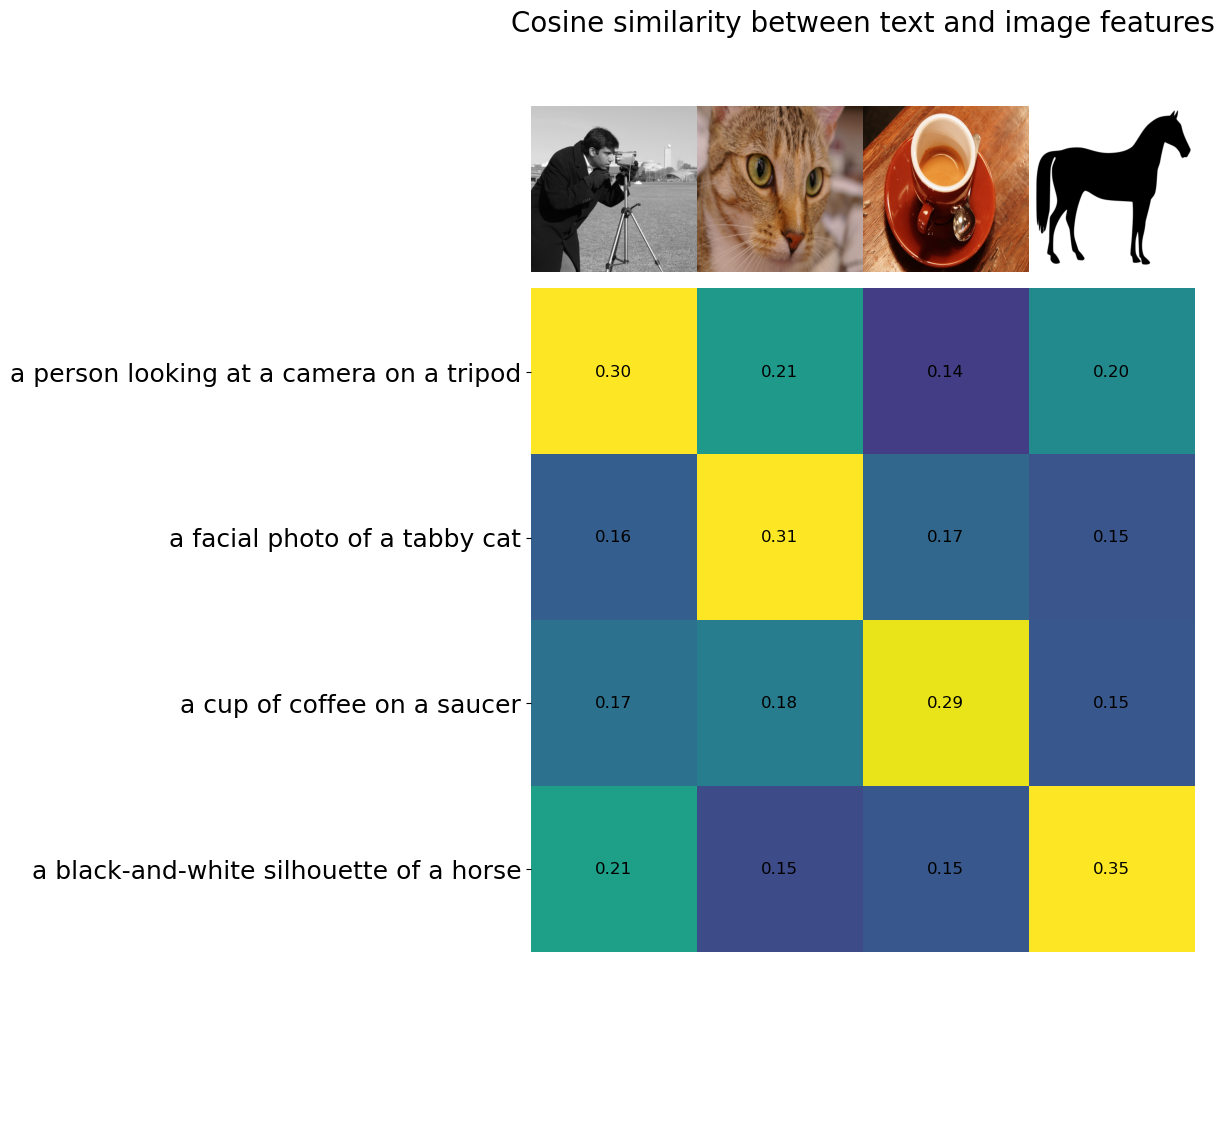

In [13]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)